# Setup

## Colab

In [1]:
# # Mount the drive and move to dir
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# from classes.models import BertPooler

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertPooler)

# Import the model
# from classes.models.BertPooler import BertPooler
from utils.inferutil import infer_full, infer_one

# Import the funcs needed from utils
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

In [3]:
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertPoolerPos",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 0,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "100",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 32,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 128,
    # Training Parameters
    "batch_size": 14,
    "lr": 5e-3,
    "mu": 0.25,
    "epochs": 20,
    "patience": 2,
    "save_int": 5,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 80/80 [00:24<00:00,  3.20it/s]



80(P) = 80(G) + 0(E)


Processing files: 100%|██████████| 10/10 [00:00<00:00, 1245.27it/s]



10(P) = 10(G) + 0(E)


Processing files: 100%|██████████| 10/10 [00:00<00:00, 4355.46it/s]



10(P) = 10(G) + 0(E)
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertPoolerPos",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "100",
  "data_dir": "../data",
  "train_dir": "../data/100_train",
  "val_dir": "../data/100_val",
  "test_dir": "../data/100_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 32,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 14,
  "lr": 0.005,
  "mu": 0.25,
  "epochs": 20,
  "patience": 2,
  "save_int": 

# Model Creation

## NEW MODEL DEFINITION HERE

In [4]:
# Import required libraries
import math

import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertPoolerPos class
class BertPoolerPos(nn.Module):

    # Init
    def __init__(self, config):

        # Initialize parent class
        super().__init__()

        # Extract parameters from config which are being used later
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create BERT config and BERT model from this config
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )  # BERT config
        self.bert = BertModel(self.bert_config)  # BERT model

        # Generate and store the matrix of cells' positional encodings
        # Size [max(rows, cols), hidden_size], first dim taken as max since it covers both
        self.pos_enc = self.get_pos_enc()

        # Create a separate config for enriched encoder
        self.enriched_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
            output_attentions=False,
            output_hidden_states=False,
        )

        # Create the enriched encoder
        self.enriched_encoder = BertEncoder(self.enriched_config)
        # print(f"\nEnriched Encoder Architecture:\n{self.enriched_encoder}")

        # Previous model layers that were applied to pooled output of self.bert
        self.dropout = nn.Dropout(self.hidden_dropout_prob)  # Dropout layer
        self.gelu = nn.GELU()  # Activation function originally applied after bert
        self.classifier = nn.Linear(self.hidden_size, 1)  # Classification head

    # Function to get positional encodings for cells
    def get_pos_enc(self):
        """
        Returns a [max_dim, hidden_size] tensor of sin/cos positional encodings where max_dim
        is the maximum between self.rows and self.cols. Can be used for both row and column
        position encoding since it covers the larger dimension.
        """
        # Max of rows/cols is the number of positions we have
        pos_dim = max(self.rows, self.cols)

        # Initialize the positional encoding matrix [pos_dim, hidden_size]
        pe = torch.zeros(pos_dim, self.hidden_size, device=self.device)

        # Create [pos_dim, 1] position vector
        pos = torch.arange(pos_dim, dtype=torch.float, device=self.device).unsqueeze(1)

        # Compute a [hidden_size/2] vector for the exponential scaling
        # This replaces repeated pow(10000, 2i/hidden_size) calls
        div_term = torch.exp(
            torch.arange(0, self.hidden_size, 2, dtype=torch.float, device=self.device)
            * (-math.log(10000.0) / self.hidden_size)
        )

        # Apply sin to even indices and cos to odd indices
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        # Return final matrix of all positional encodings
        return pe

    # Forward function for debugging now incorporating positional encodings too
    def forward2(self, input_ids, attention_mask):

        # Initialize tensor to store the enriched_encodings across all cells
        enriched_encodings = torch.zeros(
            (input_ids.shape[0], self.rows * self.cols, self.hidden_size),
            device=self.device,
        )

        # Loop through all cells in the grid
        for cell in tqdm(range(self.rows * self.cols), desc="Doing Forward"):

            # Calculate row/col indices for current cell
            row = cell // self.cols
            col = cell % self.cols

            # Get the pooled output of cell's content [batch_size, hidden_size]
            pooled_output = self.bert(
                input_ids=input_ids[:, row, col, :],
                attention_mask=attention_mask[:, row, col, :],
            ).pooler_output

            # Retrieve the [batch_size, hidden_size] positional encoding vectors for row and col
            row_pos_enc = self.pos_enc[row]
            col_pos_enc = self.pos_enc[col]

            # Add the row and column positional encodings to get cell's positional encoding [batch_size, hidden_size]
            cell_pos_enc = row_pos_enc + col_pos_enc

            # Add the positional encoding to the pooled output for enriched encoding [batch_size, hidden_size]
            cell_enriched_encoding = pooled_output + cell_pos_enc

            # Store this in the enriched_encodings tensor [batch_size, rows*cols, hidden_size]
            enriched_encodings[:, cell, :] = cell_enriched_encoding

            ## DEBUG PRINT

            # Check for specific cell 10, 20 since positional encodings for row/col different for both
            if row == 10 and col == 20:

                # Global Info
                print(f"\nHidden Size: {self.hidden_size}")
                print(f"\nPositional Encoding Matrix ({self.pos_enc.shape})")

                # Cell Position
                print(f"\nRow: {row}, Col: {col}")

                # Cell Content Pooled Output
                print(
                    f"\nCell Content's Pooled Output ({pooled_output.shape}):\n{pooled_output}"
                )

                # Row/Col Positional Encodings
                print(
                    f"\nRow Positional Encoding ({row_pos_enc.shape}):\n{row_pos_enc}"
                )
                print(
                    f"\nCol Positional Encoding ({col_pos_enc.shape}):\n{col_pos_enc}"
                )

                # Combined Cell Positional Encoding
                print(
                    f"\nCell Positional Encoding ({cell_pos_enc.shape}):\n{cell_pos_enc}"
                )

                # Cell's Enriched Encoding = Pooled Output + Cell Positional Encoding
                print(
                    f"\nCell Enriched Encoding ({cell_enriched_encoding.shape}):\n{cell_enriched_encoding}"
                )

        # After loop for cells ends pass the enriched encodings through the enriched encoder
        enriched_output = self.enriched_encoder(enriched_encodings)[0]

        # Get the processed output passing this enriched info through dropout and gelu
        processed_output = self.gelu(self.dropout(enriched_output))

        # Now use the classification head to get the logits per cell and remove last dim since there is one logit per batch per cell [batch_size, rows x cols]
        logits = self.classifier(processed_output).squeeze(-1)

        # To get S_cube, reshape logits to [batch_size, rows, cols]
        S_cube = logits.reshape(input_ids.shape[0], self.rows, self.cols)

        ## DEBUG PRINT

        # Enriched encodings and output shapes
        print(f"\nEnriched Encodings Shape: {enriched_encodings.shape}")
        print(f"\nEnriched Output Shape: {enriched_output.shape}")

        # Logits and S_cube shape
        print(f"\nLogits Shape: {logits.shape}")
        print(f"\nS_cube Shape: {S_cube.shape}")

        # Return the S_cube
        return S_cube

    # Normal optimized forward function
    def forward(self, input_ids, attention_mask):

        # Initialize and fill enriched encodings tensor
        enriched_encodings = torch.zeros(
            (input_ids.shape[0], self.rows * self.cols, self.hidden_size),
            device=self.device,
        )

        # Build enriched encodings combining content and position understanding
        for cell in range(self.rows * self.cols):

            # Define row and column indices for current cell
            row = cell // self.cols
            col = cell % self.cols

            # Calculate the enriched encoding for the cell
            enriched_encodings[:, cell, :] = (
                self.bert(
                    input_ids=input_ids[:, row, col, :],
                    attention_mask=attention_mask[:, row, col, :],
                ).pooler_output
                + self.pos_enc[row]
                + self.pos_enc[col]
            )

        # Process through encoder and classification head, reshape to grid format
        S_cube = (
            self.classifier(
                self.gelu(
                    self.dropout(self.enriched_encoder(enriched_encodings)[0])
                )
            )
            .squeeze(-1)
            .reshape(input_ids.shape[0], self.rows, self.cols)
        )

        # Return the S_cube
        return S_cube

    #         # Combined classification head operations into single inline expression
    #         S_cube[:, row, col] = self.classifier(
    #             self.gelu(
    #                 self.dropout(
    #                     self.bert(
    #                         input_ids=input_ids[:, row, col, :],
    #                         attention_mask=attention_mask[:, row, col, :],
    #                     ).pooler_output
    #                 )
    #             )
    #         ).squeeze(-1)

    #     return S_cube

    # # Function to precompute the positional encodings
    # def positional_encodings(self):

    #     # Initialize the positional encodings tensor [seq_len x hidden_size]
    #     posenc_matrix = torch.zeros((self.seq_len, self.hidden_size))

    #     # Loop through all the positions in the sequence
    #     for pos in range(self.seq_len):

    #         # Loop till hidden_size/2 to calculate the positional encodings 2 at a time for 2i and 2i + 1
    #         for i in range(self.hidden_size // 2):

    #             # Calculate the common denominator for both 2i, 2i+1 positions
    #             denom = 10000 ** ((2 * i) / self.hidden_size)

    #             # Fill sin value at even indices (2i)
    #             posenc_matrix[pos, 2 * i] = math.sin(pos / denom)

    #             # Fill cos value at odd indices (2i+1)
    #             posenc_matrix[pos, 2 * i + 1] = math.cos(pos / denom)

    #     # Return the positional encodings matrix
    #     return posenc_matrix

    # def forward(self, input_ids, attention_mask):
    #     # Extract dimensions from input
    #     batch_size, rows, cols, seq_len = input_ids.shape

    #     # Initialize output tensor
    #     S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)

    #     # Process each cell in the grid
    #     for cell in range(rows * cols):
    #         # Calculate row and column indices
    #         row = cell // cols
    #         col = cell % cols

    #         # Combined classification head operations into single inline expression
    #         S_cube[:, row, col] = self.classifier(
    #             self.gelu(
    #                 self.dropout(
    #                     self.bert(
    #                         input_ids=input_ids[:, row, col, :],
    #                         attention_mask=attention_mask[:, row, col, :],
    #                     ).pooler_output
    #                 )
    #             )
    #         ).squeeze(-1)

    #     return S_cube

### Single Batch Checking

In [5]:
torch.set_printoptions(precision=4, sci_mode=False)

# # Define parameters where loc is the index of file and test_batch_size is the batch size for testing
# test_batch_size = 1

# # Create check loader from the train_loader Dataset
# check_loader = torch.utils.data.DataLoader(
#     train_loader, batch_size=test_batch_size, shuffle=False
# )

# # Get first batch using next() and iter()
# check_batch = next(iter(check_loader))

# # Extract all the relevant tensors/info at loc
# ex_file = check_batch["file_paths"]
# ex_xtok = check_batch["x_tok"].to(DEVICE)
# ex_xmasks = check_batch["x_masks"].to(DEVICE)
# ex_ytok = check_batch["y_tok"]

# # Print the extracted info
# print(f"Filename: {ex_file}")
# print(f"x_tok shape: {ex_xtok.shape}")
# print(f"x_masks shape: {ex_xmasks.shape}")
# print(f"y_tok shape: {ex_ytok.shape}\n")

# Define the model and move it to the device
untrained_model = BertPoolerPos(config).to(DEVICE)
print(untrained_model)

"""
NOTE: Model takes up 521 Mb with hidden 32 and intermediate 128
"""

BertPoolerPos(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 32, padding_idx=0)
      (position_embeddings): Embedding(64, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
        

'\nNOTE: Model takes up 521 Mb with hidden 32 and intermediate 128\n'

In [6]:
# # Now do a single forward pass and see outputs
# out = untrained_model.forward2(ex_xtok, ex_xmasks)
# print(f"\nOutput ({out.shape}):\n{out}")

# # Check sigmoid vals also
# print(f"\nSigmoid Output:\n{torch.sigmoid(out)}")

In [7]:
# # 1) Create model and move to GPU Observe its architecture - 440 Mib
# untrained_model = BertPooler(config).to(DEVICE)
# print(untrained_model)

# Model Training

In [8]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
)

"""
NOTE:

Batch Size 14 maxes out GPU usage at 39/40 GB and takes 01:49 mins per epoch

Batch size 10 had more buffer with 28/40 GB used, but took 02:30 mins per epoch
"""

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.42s/it]


Train Loss: 1.210826317469279, Perplexity: 1.0000086487968112
Val Loss: 0.9166435599327087, Perplexity: 1.000006547475434


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.57s/it]


Train Loss: 0.8634733557701111, Perplexity: 1.000006167685847
Val Loss: 0.48986929655075073, Perplexity: 1.0000034990725257


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


Train Loss: 0.5056980599959692, Perplexity: 1.0000036121355238
Val Loss: 0.3335285186767578, Perplexity: 1.0000023823493998


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.62s/it]


Train Loss: 0.35927654802799225, Perplexity: 1.0000025662643501
Val Loss: 0.2601149082183838, Perplexity: 1.0000018579653562


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.78s/it]


Train Loss: 0.30208337555329007, Perplexity: 1.0000021577407248
Val Loss: 0.22410652041435242, Perplexity: 1.0000016007621413

Model Saved

Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.56s/it]


Train Loss: 0.26980190972487134, Perplexity: 1.000001927158355
Val Loss: 0.20326906442642212, Perplexity: 1.0000014519229428


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.59s/it]


Train Loss: 0.247940331697464, Perplexity: 1.0000017710039375
Val Loss: 0.1868457943201065, Perplexity: 1.000001334613707


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.79s/it]


Train Loss: 0.23634162048498789, Perplexity: 1.0000016881558569
Val Loss: 0.18989163637161255, Perplexity: 1.0000013563697512


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.67s/it]


Train Loss: 0.22110576927661896, Perplexity: 1.0000015793281705
Val Loss: 0.23674160242080688, Perplexity: 1.0000016910128757


EARLY STOPPING at epoch 8, best epoch 6
Train Loss = 0.247940331697464, Perplexity = 1.0000017710039375
Val Loss = 0.1868457943201065, Perplexity = 1.000001334613707


TRAINING DONE at epoch 8, best epoch 6
Train Loss = 0.247940331697464, Perplexity = 1.0000017710039375
Val Loss = 0.1868457943201065, Perplexity = 1.000001334613707


'\nNOTE: \n\nBatch Size 14 maxes out GPU usage at 39/40 GB and takes 01:49 mins per epoch\n\nBatch size 10 had more buffer with 28/40 GB used, but took 02:30 mins per epoch\n'

# Evaluation

## Single Example


Filename: ../data/100_train/ALFA_Parameters.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(8,5): 0.93092745542526245117
(18,4): 0.93219506740570068359
(11,3): 0.93294006586074829102
(21,1): 0.93323129415512084961
(24,0): 0.93324923515319824219
(2,2): 0.93410462141036987305
(5,1): 0.93453359603881835938

NB to B ratio: Predicted = 9916:84 | Actual = 9993:7
Accuracy: 99.23% | Precision: 8.33% | Recall: 100.00% | F1-Score: 0.15



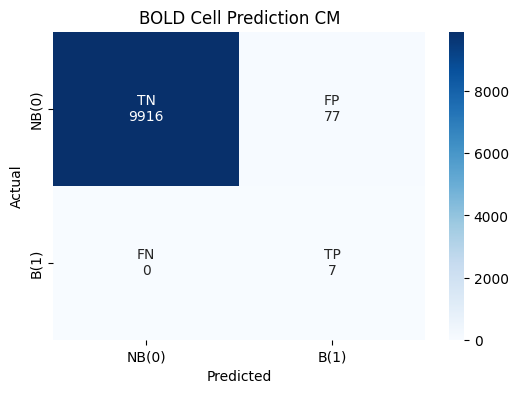


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,1,1,1,1,1,1
1,0,1,1,1,1,1,0
2,1,1,1,1,1,1,0
4,0,1,1,1,1,1,0
5,1,1,0,0,1,0,0
7,0,1,1,1,1,1,0
8,1,1,1,1,0,1,0
10,0,1,1,1,1,1,1
11,1,0,1,1,0,0,0
13,0,1,1,1,1,1,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5
2,0,0,1,0,0,0
5,0,1,0,0,0,0
8,0,0,0,0,0,1
11,0,0,0,1,0,0
18,0,0,0,0,1,0
21,0,1,0,0,0,0
24,1,0,0,0,0,0


In [32]:
# Params
loc = 0
thresh = 0.93

# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/100_val/LMDI_Combined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 9950:50 | Actual = 10000:0
Accuracy: 99.50% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



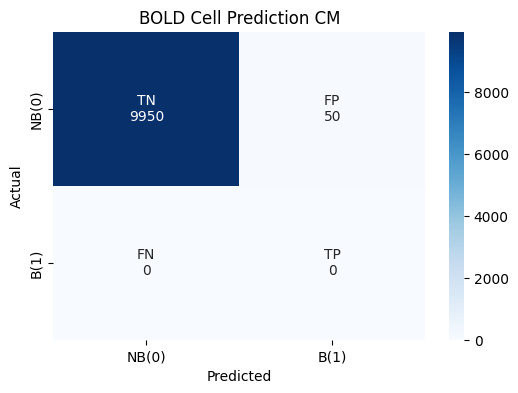


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3
0,1,1,0,1
1,1,0,1,1
2,1,1,1,1
3,1,0,1,1
4,1,1,1,0
5,1,1,1,1
6,1,1,1,1
9,1,1,0,1
10,1,1,1,1
11,1,0,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.


In [33]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/100_test/1415-bassessment-1.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(8,4): 0.92966681718826293945
(8,6): 0.93005162477493286133
(8,5): 0.93070644140243530273
(8,3): 0.93263036012649536133
(8,2): 0.93335318565368652344
(8,0): 0.93370175361633300781
(6,0): 0.93388009071350097656
(8,1): 0.93396514654159545898

NB to B ratio: Predicted = 9895:105 | Actual = 9992:8
Accuracy: 99.01% | Precision: 6.67% | Recall: 87.50% | F1-Score: 0.12



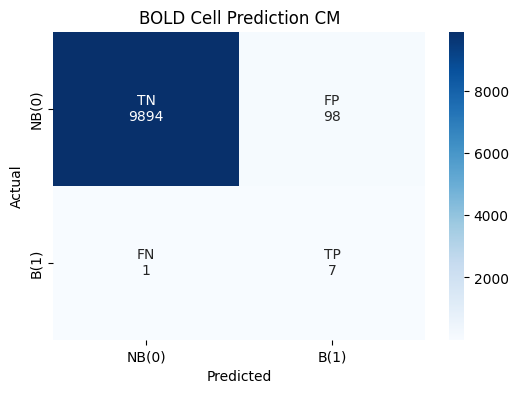


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,1,0,0,0,0,0
1,1,1,0,0,0,0,0
2,1,1,0,0,0,0,0
3,1,1,0,0,0,0,0
4,1,1,0,0,0,0,0
6,1,0,0,0,0,0,0
8,1,1,1,1,0,1,1
9,0,1,1,1,1,1,0
10,0,0,1,0,1,1,0
11,1,1,1,0,1,1,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
6,1,0,0,0,0,0,0
8,1,1,1,1,1,1,1


In [34]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

## All Examples

Batch Inference: 100%|██████████| 8/8 [01:52<00:00, 14.09s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 793131:6869 | Actual = 798240:1760
Accuracy: 99.24% | Precision: 17.29% | Recall: 75.17% | F1-Score: 0.27



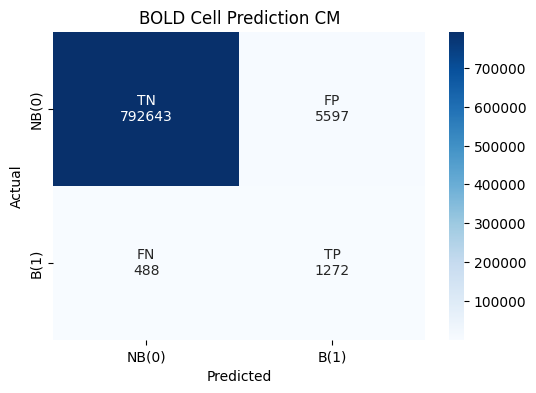

In [35]:
# Determine batch size to use for inference
infer_batch_size = 10

# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

In [ ]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=0.9331,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)